In [ ]:
pip install --upgrade pip

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.1 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [6]:
!pip install tensorflow

In [4]:
!pip install wurlitzer


In [5]:
!pip install tensorflow-decision-forests

In [7]:
!pip install numpy==1.25
!pip install typeguard==4.1.2

In [8]:
import os
import itertools
from PIL import Image

In [9]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, Adamax

2024-04-10 20:23:57.914371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 20:23:57.914466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 20:23:58.035467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Get Paths of Training and testing directories

Training = '/kaggle/input/brain-tumor-mri-dataset/Training'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directories to lists

tr_dir = os.listdir(Training)

In [13]:

for i in tr_dir:
    classpath = os.path.join(Training, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

In [14]:

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Tr_data = pd.concat([Paths, Labels], axis = 1)

In [15]:

Testing = '/kaggle/input/brain-tumor-mri-dataset/Testing'


# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directories to lists

ts_dir = os.listdir(Testing)

In [16]:
for i in ts_dir:
    classpath = os.path.join(Testing, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

In [17]:
Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Ts_data = pd.concat([Paths, Labels], axis = 1)

In [18]:
Tr_data.shape

(5712, 2)

In [19]:
Tr_data.head()

,Paths,Labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [20]:
Ts_data.shape

(1311, 2)

In [21]:
Ts_data.head()

,Paths,Labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


In [22]:
valid_df, test_df = train_test_split(Ts_data, train_size = 0.5, shuffle = True, random_state = 123)
print(valid_df.shape)
print(test_df.shape)

(655, 2)
(656, 2)


In [23]:

batch_size = 20
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

Tr_G = ImageDataGenerator(fill_mode='nearest')

Val_G = ImageDataGenerator()

Test_G = ImageDataGenerator()

In [24]:
Train = Tr_G.flow_from_dataframe(Tr_data, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.


In [25]:
Valid = Val_G.flow_from_dataframe(valid_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

Found 655 validated image filenames belonging to 4 classes.


In [26]:
Test = Test_G.flow_from_dataframe(test_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 656 validated image filenames belonging to 4 classes.


In [27]:
L_index = Train.class_indices
L_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [28]:
Keys = list(L_index.keys())
Keys

['glioma', 'meningioma', 'notumor', 'pituitary']

In [29]:
imgs, labels = next(Train)

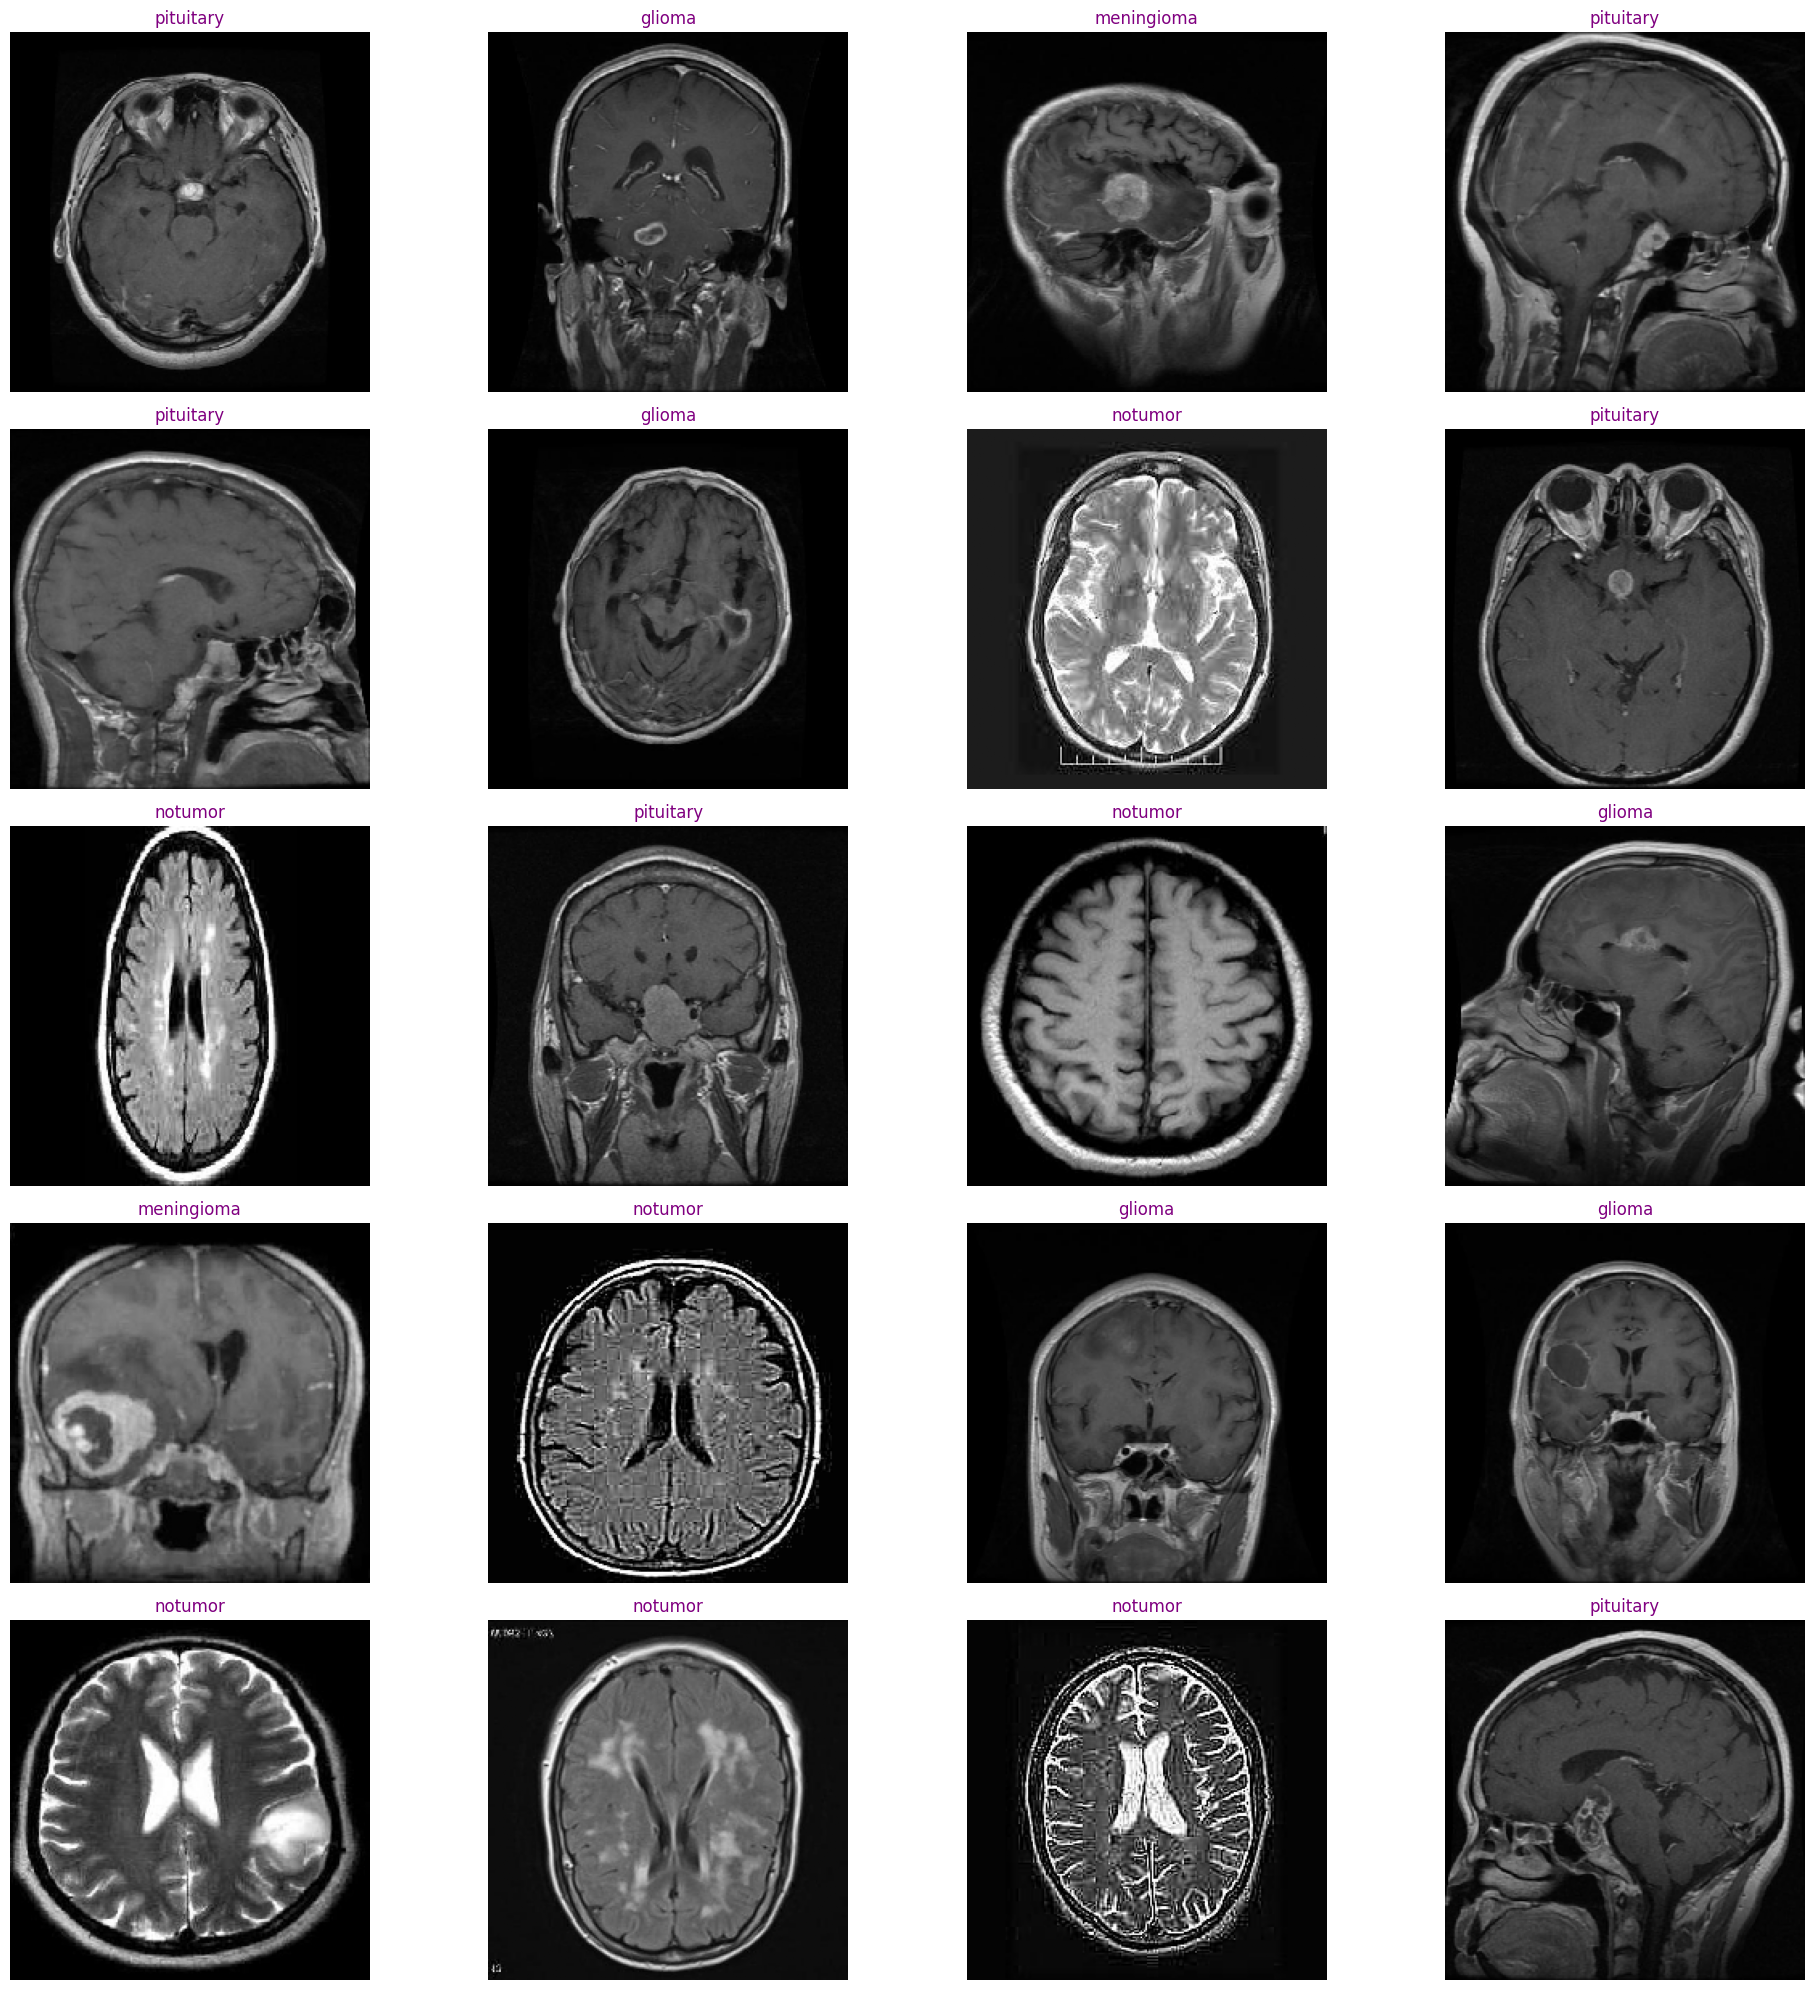

In [30]:
plt.figure(figsize= (20, 20))

for i in range(20):
    plt.subplot(5, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()


In [31]:
Train


In [32]:
# Define number of classes 
counter_classes = len(list(Train.class_indices.keys()))
counter_classes

4

In [33]:
CNN = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu', input_shape = img_shape),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
     Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(256, activation = 'elu'),
    Dense(128, activation = 'elu'),
    Dense(64, activation = 'elu'),
    Dense(32, activation = 'elu'),
    Dense(counter_classes, activation = 'softmax')
])

In [34]:
CNN.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = 'accuracy')

In [35]:
CNN.compile(optimizer=Adamax(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [36]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 128)     0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 256)     295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 256)     590080    
                                                        

In [37]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

In [38]:
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"

test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

img_size = (224 , 224)

batch_size = 32

In [39]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "int" ,
    batch_size = batch_size ,
    )

#Define Classes Names
class_names= train_data.class_names
class_names


Found 5712 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

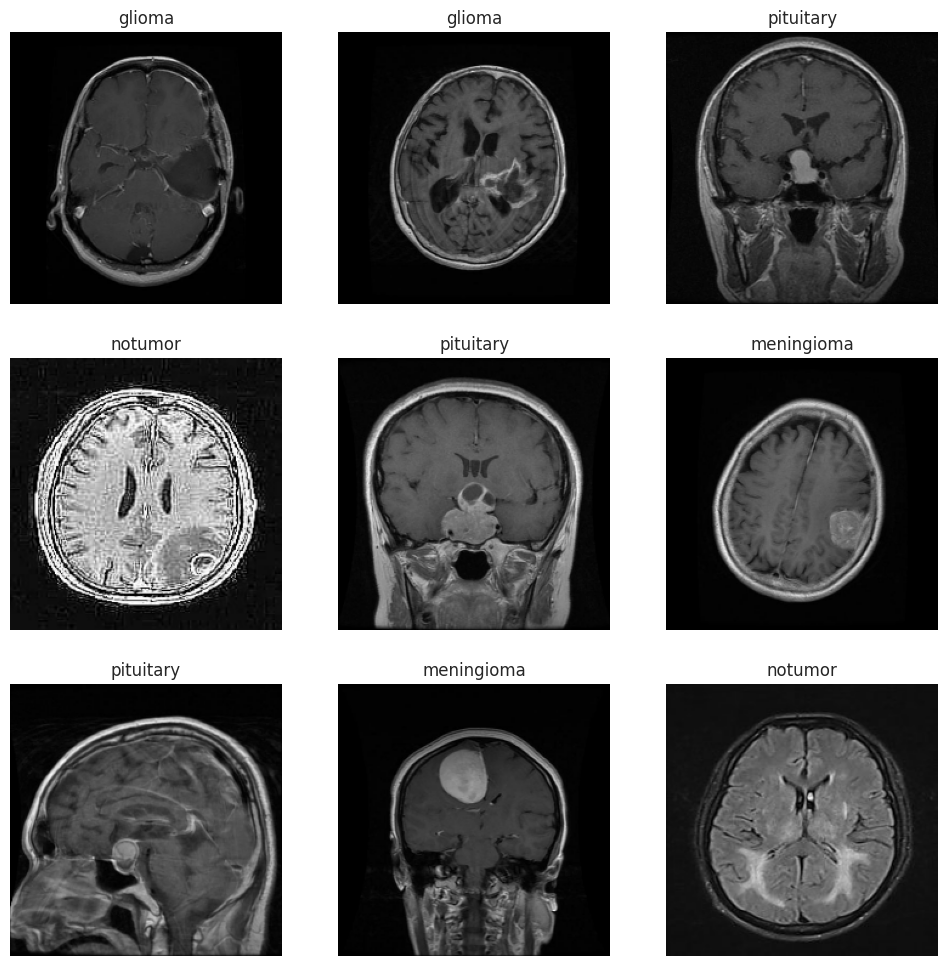

In [40]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [41]:
def each_class_samples(train_data):
    """
    taking the train data and returns the number of each class samples 
    
    """
    #Set up counters
    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1   
    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))
    return [meningioma , glioma , notumor , pituitary]

meningioma  , glioma , notumor , pituitary = each_class_samples(train_data)

meningioma : 1339
glioma : 1321
notumor : 1595
pituitary : 1457


In [42]:
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h' ,) )

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

In [43]:
img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)
callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [44]:

base_model = tf.keras.applications.EfficientNetB0(include_top = False) #excluding the top layer 

base_model.trainable = False #--> Freezing the model parameters (Make it's parameter not learnable)

inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer") #--> Define the input layer

x = base_model(inputs) 
x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x) #--> add a Conv2D layer which we will use in the segmentation as the Top conv Layer

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x) #--> Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4 , #--> Because we have 4 Classes
                                activation = "softmax" , #we will change it to linear when we apply sigmentation
                                name = "Output_layer")(x) 
Model_1 = tf.keras.Model(inputs , outputs) #--> Defining the model 
Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#--> Multiclass classification
    optimizer = tf.keras.optimizers.Adam() , #--> Adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy'] 
)

Model_1_History = Model_1.fit(train_data 
                              , validation_data = test_data ,
                              epochs = 5  ,
                              verbose = 1 ,
                              callbacks = callback_list)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/5


2024-04-10 20:36:22.831071: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1712781386.315442     206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 [==============================] - 30s 106ms/step - loss: 0.4129 - accuracy: 0.8468 - val_loss: 0.2602 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 2/5
179/179 [==============================] - 14s 76ms/step - loss: 0.2087 - accuracy: 0.9214 - val_loss: 0.2266 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 3/5
179/179 [==============================] - 14s 76ms/step - loss: 0.1602 - accuracy: 0.9431 - val_loss: 0.1682 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 4/5
179/179 [==============================] - 14s 76ms/step - loss: 0.1221 - accuracy: 0.9531 - val_loss: 0.1437 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 5/5
179/179 [==============================] - 14s 76ms/step - loss: 0.1029 - accuracy: 0.9641 - val_loss: 0.1335 - val_accuracy: 0.9466 - lr: 0.0010


In [45]:
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

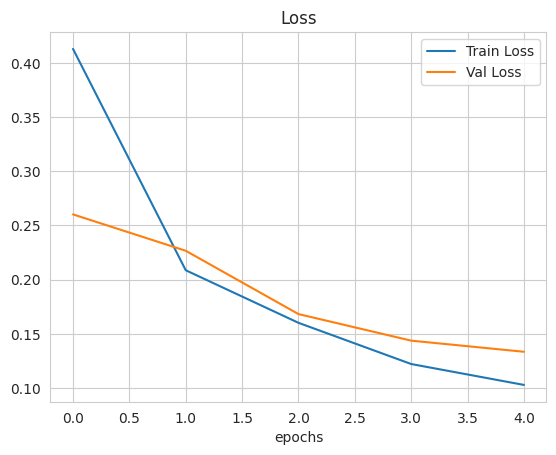

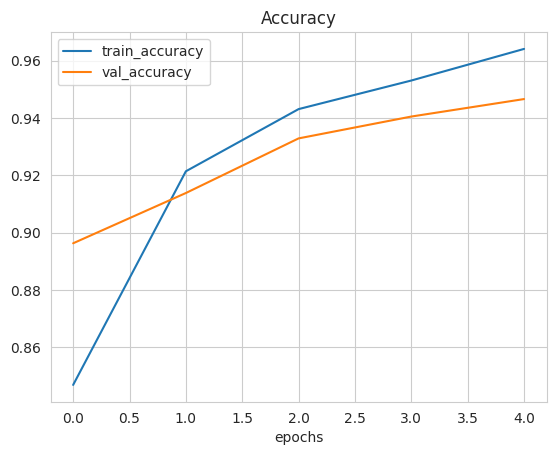

In [46]:
plot_loss_curves(Model_1_History)

In [47]:
base_model.trainable = True

#Freezing all the layers except last 10 
for layer in base_model.layers[:-10]:
    layer.trainable = False


#ReCompile the model 
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #--< When FineTuning u want to lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 5

Fine_Tune_epoch = initial_epoch + 5

#Refit the model 
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch , 
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 5/10


2024-04-10 20:39:46.775506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 25s 88ms/step - loss: 0.1048 - accuracy: 0.9646 - val_loss: 0.0942 - val_accuracy: 0.9657
Epoch 6/10
179/179 [==============================] - 14s 78ms/step - loss: 0.0565 - accuracy: 0.9820 - val_loss: 0.0831 - val_accuracy: 0.9718
Epoch 7/10
179/179 [==============================] - 14s 79ms/step - loss: 0.0495 - accuracy: 0.9853 - val_loss: 0.0630 - val_accuracy: 0.9710
Epoch 8/10
179/179 [==============================] - 14s 78ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.0544 - val_accuracy: 0.9771
Epoch 9/10
179/179 [==============================] - 14s 78ms/step - loss: 0.0314 - accuracy: 0.9911 - val_loss: 0.0586 - val_accuracy: 0.9771
Epoch 10/10
179/179 [==============================] - 14s 78ms/step - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.0521 - val_accuracy: 0.9794


In [48]:
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch , 
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 10/11


2024-04-10 20:42:01.072531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 24s 88ms/step - loss: 0.0164 - accuracy: 0.9974 - val_loss: 0.0451 - val_accuracy: 0.9855
Epoch 11/11
179/179 [==============================] - 14s 79ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.0436 - val_accuracy: 0.9809


In [58]:
last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array




def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))
def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
        
def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction
def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]



1/1 [==============================] - 3s 3s/step
meningioma


(-0.5, 317.5, 353.5, -0.5)

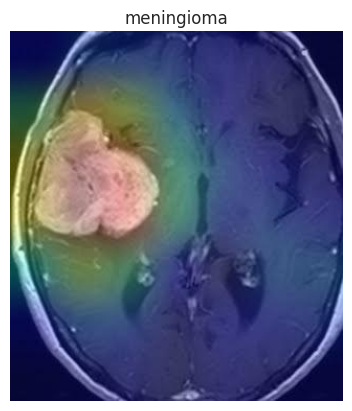

In [59]:
campath , prediction = make_prediction("/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

1/1 [==============================] - 0s 26ms/step


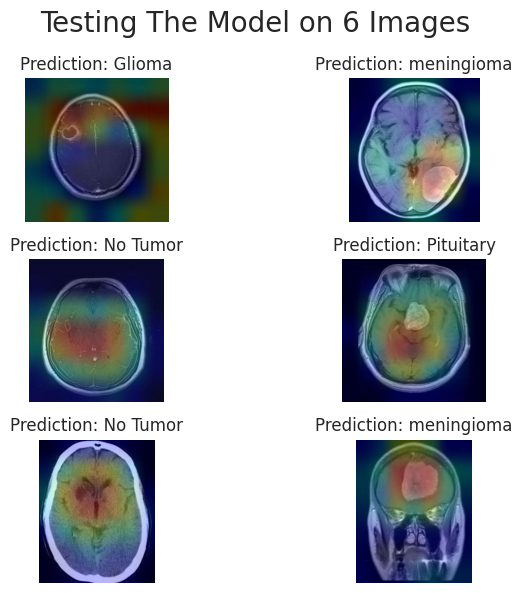

In [90]:
import matplotlib.pyplot as plt
from PIL import Image

path_array = [
    '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0025.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0017.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0054.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0025.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0034.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0028.jpg'
]

# Create a 3x2 grid of subplots with a slight size adjustment
fig, axes = plt.subplots(3, 2, figsize=(8, 6))  # Increased figure width slightly
fig.suptitle("Testing The Model on 6 Images", fontsize=20)  # Updated title for 6 images

for i, path in enumerate(path_array):
    campath, prediction = make_prediction(path, campath=f"{i}.jpeg")
    test_img = plt.imread(campath)

    # Access current subplot using 2D indexing for 3x2 grid
    ax = axes[i // 2, i % 2]  # Divide by 2 for rows, mod 2 for columns
    ax.imshow(test_img)
    ax.set_title(f"Prediction: {prediction}")
    ax.axis("off")

plt.tight_layout()
plt.show()
